# Convolutional deep autoencoder on mnist (deprecated - for keras before backends)

This is an experiment training a convolutional autoencoder on the MNIST database using keras.

This is heavily inspired by [this blog article](https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/), but it uses keras instead of Lasagne.

We experiment with 10 and 2 neurons in the representation layer (the deepest layer).

Thanks to [@isaacgerg](https://github.com/isaacgerg) for his help fixing some issues.

### Imports and utility functions

In [1]:
import os
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32'
#os.environ['THEANO_FLAGS']='mode=FAST_COMPILE,device=gpu,floatX=float32'
#os.environ['THEANO_FLAGS']='device=gpu0'

In [2]:
import theano
print theano.config.device

gpu0


Using gpu device 0: Tesla M2075 (CNMeM is disabled)


In [3]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import numpy as np
import theano.tensor as T
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
import keras.layers.containers as containers
from keras.layers.noise import GaussianNoise
import keras.models as models
import keras.layers.containers as containers
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, AutoEncoder, Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.regularizers import ActivityRegularizer

Using Theano backend.


In [4]:
np.set_printoptions(precision=5, suppress=True)

In [5]:
%matplotlib inline

In [6]:
# Some utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
    
def compare_input_reconstruction(input_img, rec_img, repr_activation, clsname='', fig=None):
    """
    Utility function to show input digit and autoencoder reconstruction
    
    Args:
        input_img: A 2D input image
        rec_img: The 2D reconstructed image
        repr_activation: The activation of the representation neurons
    """
    if fig is None:
        fig = pl.figure(figsize=(15, 5))
    ax = pl.subplot(131)
    ax.set_title('input image (class = %s)' % clsname)
    nice_imshow(ax, input_img, vmin=0, vmax=1, cmap=cm.binary)
     
    ax = pl.subplot(132)
    ax.set_title('reconstruction')
    nice_imshow(ax, rec_img, vmin=0, vmax=1, cmap=cm.binary)
    
    ax = pl.subplot(133)
    
    bar_centers = np.arange(len(repr_activation))
    ax.set_title('representation neurons activation')
    ax.bar(bar_centers, repr_activation, width=0.8, align='center')
    pl.xticks(bar_centers, bar_centers)
    pl.xlim((-0.5, bar_centers[-1] + 0.5))
    
    pl.tight_layout()

In [7]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train, y_train = X_train[:10000], y_train[:10000]

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


label :  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


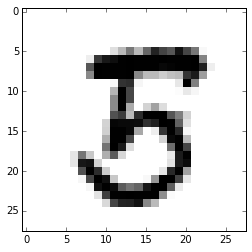

In [8]:
i = 4600
pl.imshow(X_train[i, 0], interpolation='nearest', cmap=cm.binary)
print("label : ", Y_train[i,:])

In [9]:
X_train.shape

(60000, 1, 28, 28)

## Autoencoder with 10 representation units

This part trains an autoencoder with two convolutional layers and 10 neurons at the representation (deepest) layer. We use linear activation everywhere.

In [10]:
# TODO: For some reason, this doesn't do the exact same thing as UpSampling2D. Not sure why
class UnPooling2D(Layer):
    """A 2D Repeat layer"""
    def __init__(self, poolsize=(2, 2)):
        super(UnPooling2D, self).__init__()
        self.input = T.tensor4()
        self.poolsize = poolsize
        
    @property
    def output_shape(self):
        input_shape = self.input_shape
        return (input_shape[0], input_shape[1],
                self.poolsize[0] * input_shape[2],
                self.poolsize[1] * input_shape[3])

    def get_output(self, train):
        X = self.get_input(train)
        s1 = self.poolsize[0]
        s2 = self.poolsize[1]
        output = X.repeat(s1, axis=2).repeat(s2, axis=3)
        return output

    def get_config(self):
        return {"name":self.__class__.__name__,
            "poolsize":self.poolsize}

In [11]:
# - Build the encoder pipeline
encoder = models.Sequential()
encoder.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28,28)))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
encoder.add(Convolution2D(32, 3, 3, border_mode='valid'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
encoder.add(Flatten())
encoder.add(Dense(128))
encoder.add(Dense(10))

encode = theano.function([encoder.get_input(train=False)], encoder.get_output(train=False))

# - Decoder
decoder = models.Sequential()
decoder.add(Dense(128, input_shape=(10,)))
decoder.add(Dense(32*5*5))
decoder.add(Reshape(dims=(32, 5, 5)))
#decoder.add(UpSampling2D(size=(2,2)))
decoder.add(UnPooling2D(poolsize=(2,2)))
decoder.add(ZeroPadding2D(padding=(1,1)))
decoder.add(Convolution2D(32, 3, 3, border_mode='same'))
#decoder.add(UpSampling2D(size=(2,2)))
decoder.add(UnPooling2D(poolsize=(2,2)))
decoder.add(ZeroPadding2D(padding=(2,2)))
decoder.add(Convolution2D(1, 5, 5, border_mode='same'))

decode = theano.function([decoder.get_input(train=False)], decoder.get_output(train=False))

# - Chain everything to build model
model = models.Sequential()

# Add a noise layer to get a denoising autoencoder. This helps avoid overfitting
inlayer = GaussianNoise(sigma=0.3, input_shape=(1, 28,28))

model.add(inlayer)
model.add(encoder)
model.add(decoder)

#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
model.compile(loss='mean_squared_error', optimizer='adadelta')

We display a graphical representation of the encoder (you can do the same for model an decoder to explore). 
You can see that the last layer has an output shape of 10.

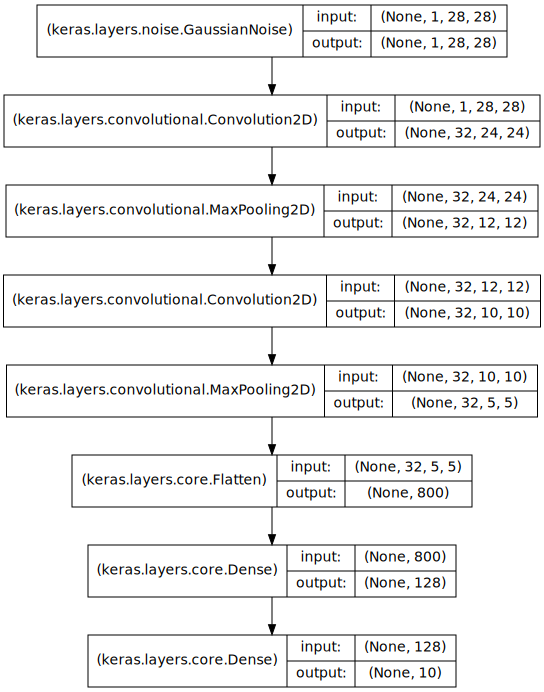

In [12]:
import keras.utils.visualize_util as vutil
from IPython.display import SVG

#SVG(vutil.to_graph(model, recursive=True, show_shape=True).create(prog='dot', format="svg"))
SVG(vutil.to_graph(encoder, recursive=True, show_shape=True).create(prog='dot', format="svg"))
#SVG(vutil.to_graph(decoder, recursive=True, show_shape=True).create(prog='dot', format="svg"))

A theano function to get the representation of a given input (without reconstructing it)

X_enc.shape :  (5, 10)
X_rec.shape :  (2, 1, 28, 28)


<matplotlib.colorbar.Colorbar instance at 0x7febb1a5cea8>

/home/julien.rebetez/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


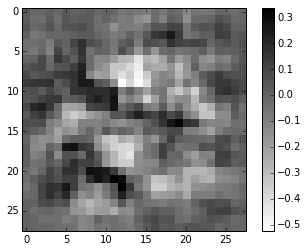

In [13]:
# Of course we'll get random results here because this is with an untrained autoencoder
X_enc = encode(X_train[0:5])
print("X_enc.shape : ", X_enc.shape)

X_rec = decode(np.random.random((2, 10)).astype(np.float32))
print("X_rec.shape : ", X_rec.shape)

X_pred = model.predict(X_train[0:5])

pl.imshow(X_pred[0].squeeze(), interpolation='nearest', cmap=cm.binary)
pl.colorbar()

Ok, so let's train it

In [14]:
nb_epoch = 10
batch_size = 128

history = model.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s - loss: 0.0557 - acc: 0.1366 - val_loss: 0.0390 - val_acc: 0.1682
Epoch 2/10
60000/60000 [==============================] - 49s - loss: 0.0389 - acc: 0.1739 - val_loss: 0.0416 - val_acc: 0.1742
Epoch 3/10
60000/60000 [==============================] - 49s - loss: 0.0376 - acc: 0.1790 - val_loss: 0.0365 - val_acc: 0.1958
Epoch 4/10
60000/60000 [==============================] - 49s - loss: 0.0371 - acc: 0.1823 - val_loss: 0.0368 - val_acc: 0.1993
Epoch 5/10
60000/60000 [==============================] - 49s - loss: 0.0368 - acc: 0.1849 - val_loss: 0.0377 - val_acc: 0.1993
Epoch 6/10
60000/60000 [==============================] - 49s - loss: 0.0367 - acc: 0.1882 - val_loss: 0.0424 - val_acc: 0.1853
Epoch 7/10
60000/60000 [==============================] - 49s - loss: 0.0365 - acc: 0.1889 - val_loss: 0.0439 - val_acc: 0.1845
Epoch 8/10
60000/60000 [==============================

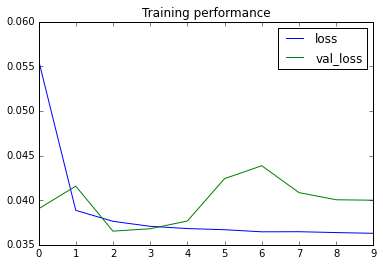

In [15]:
pl.figure()
pl.title('Training performance')
pl.plot(history.epoch, history.history['loss'], label='loss')
pl.plot(history.epoch, history.history['val_loss'], label='val_loss')
pl.legend()

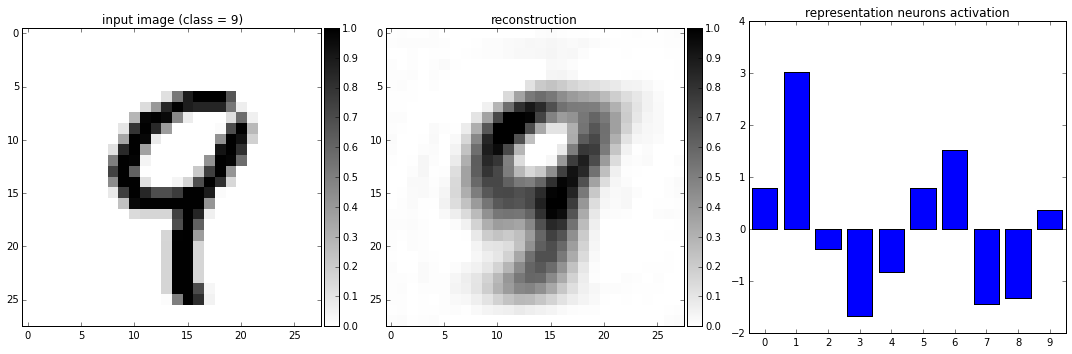

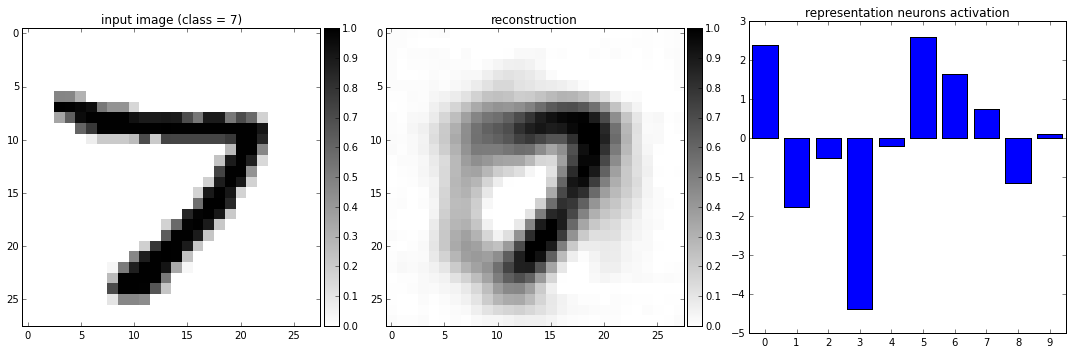

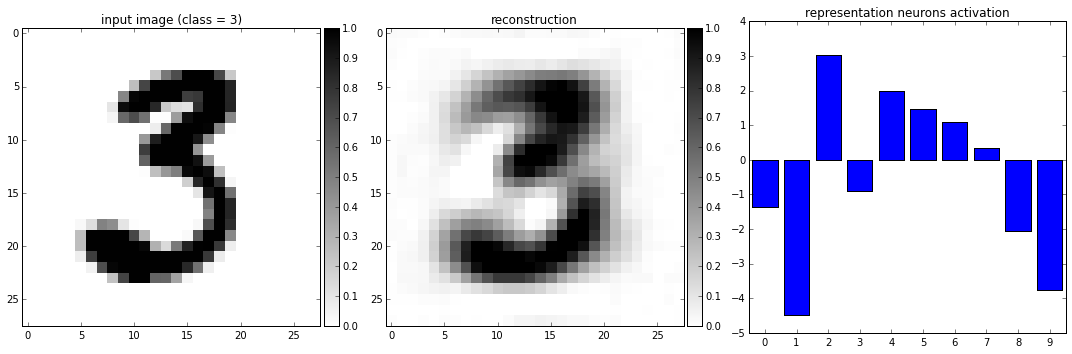

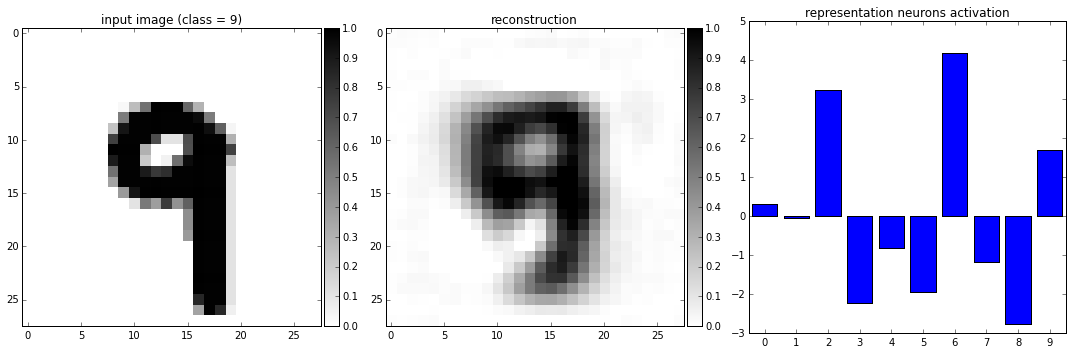

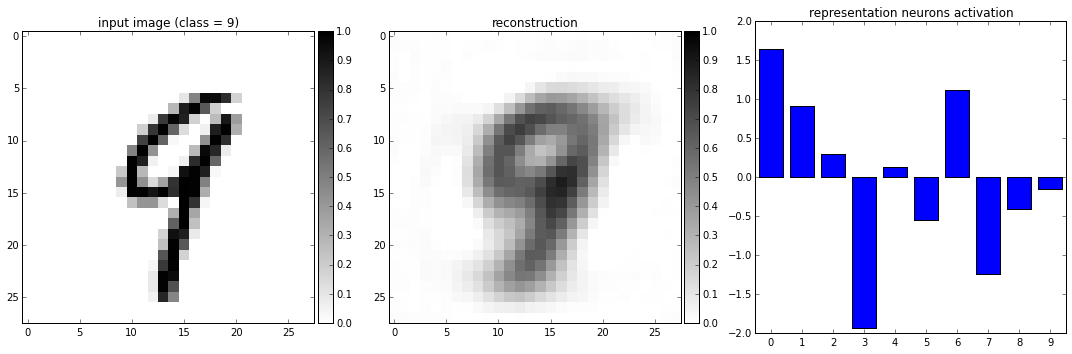

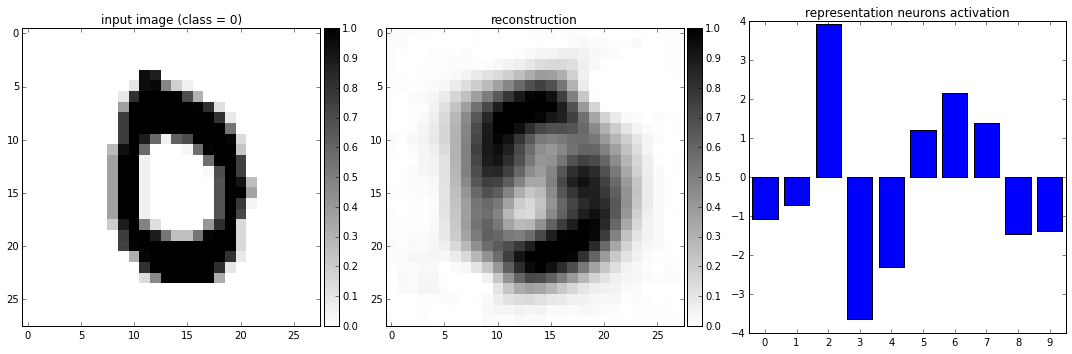

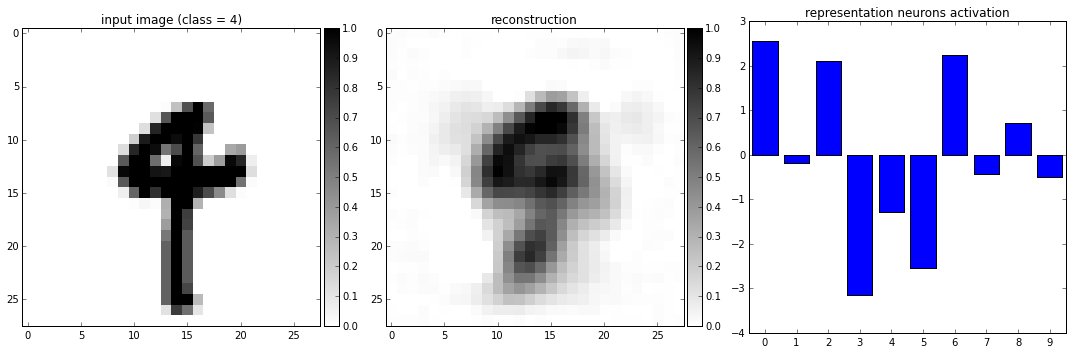

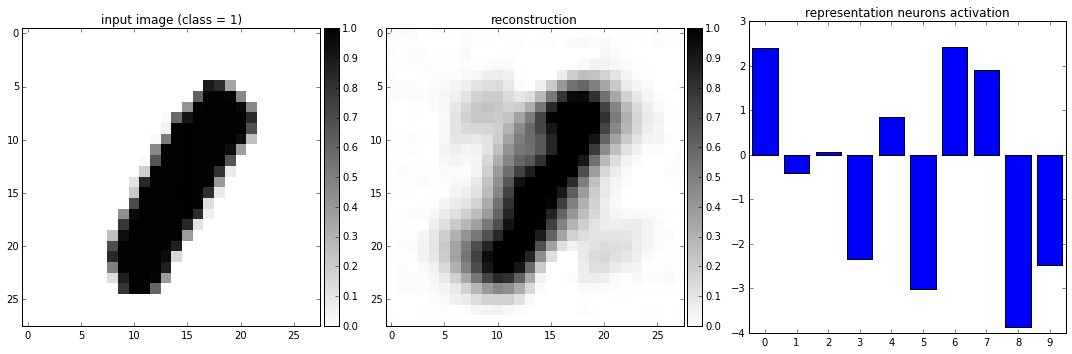

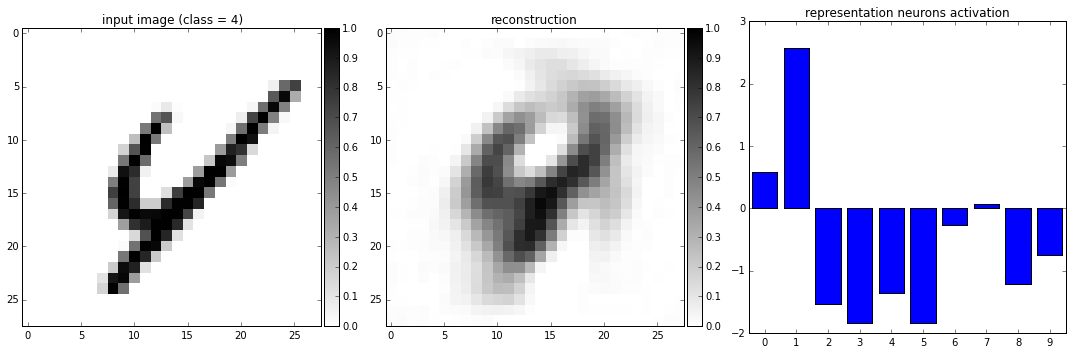

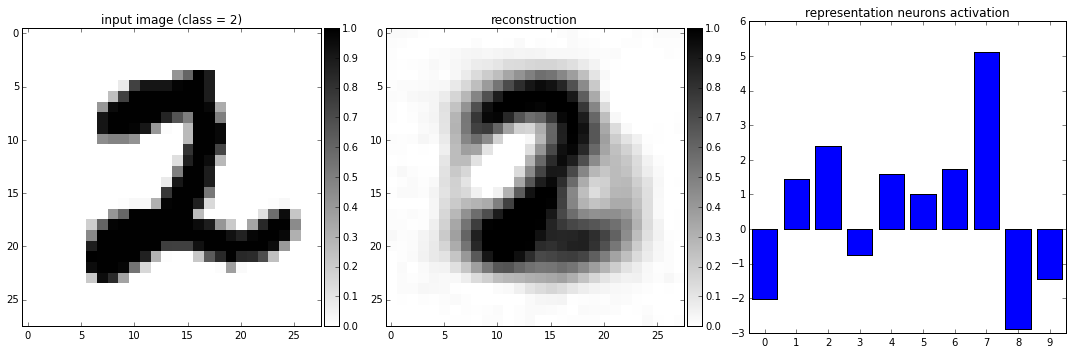

In [16]:
import random
indices = np.array(random.sample(xrange(X_test.shape[0]), 10))
X = X_test[indices]
X_pred = model.predict(X)
X_repr = encode(X)

for i in xrange(X.shape[0]):
    compare_input_reconstruction(X[i].squeeze(), X_pred[i].squeeze(), X_repr[i],
                                clsname=y_test[indices[i]])

Now, for each class of digit, we can plot the average activation of each representation neuron. Unfortunately, as we see below (based on the error bars), it varies a lot.

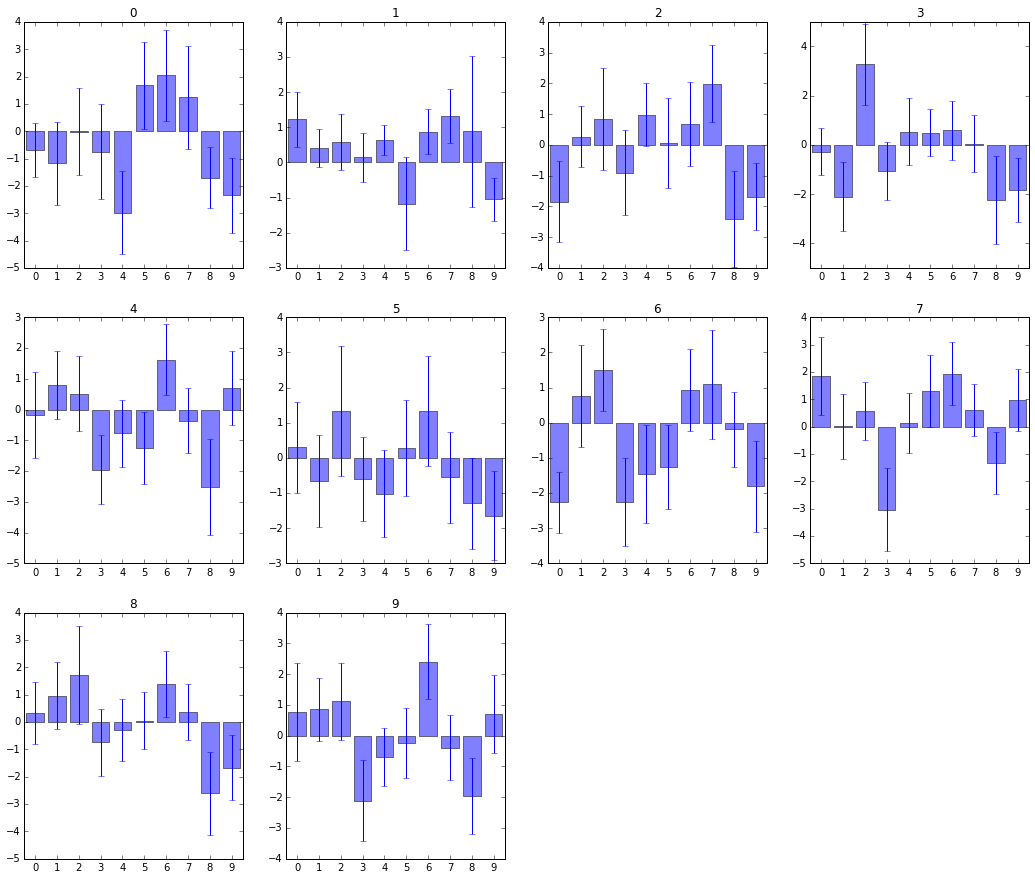

In [17]:
X_test_repr = encode(X_test)

# For each label, plot an histogram of the encoding of
# all test example that belong to said label

pl.figure(figsize=(18, 15))
for label in np.unique(y_test):
    pl.subplot(3, 4, label + 1)
    pl.title(label)
    encodings = X_test_repr[y_test == label]
    
    # encodings is nexamples x 10
    means = np.mean(encodings, axis=0)
    stds = np.std(encodings, axis=0)
    
    bar_centers = np.arange(X_test_repr.shape[1])
    pl.bar(bar_centers, means, width=0.8, align='center', yerr=stds, alpha=0.5)
    pl.xticks(bar_centers, bar_centers)
    pl.xlim((-0.5, bar_centers[-1] + 0.5))
    #pl.ylim((0, 0.3))

By activating a single representation neuron at a time, we can get our decoder to generate parts of digits

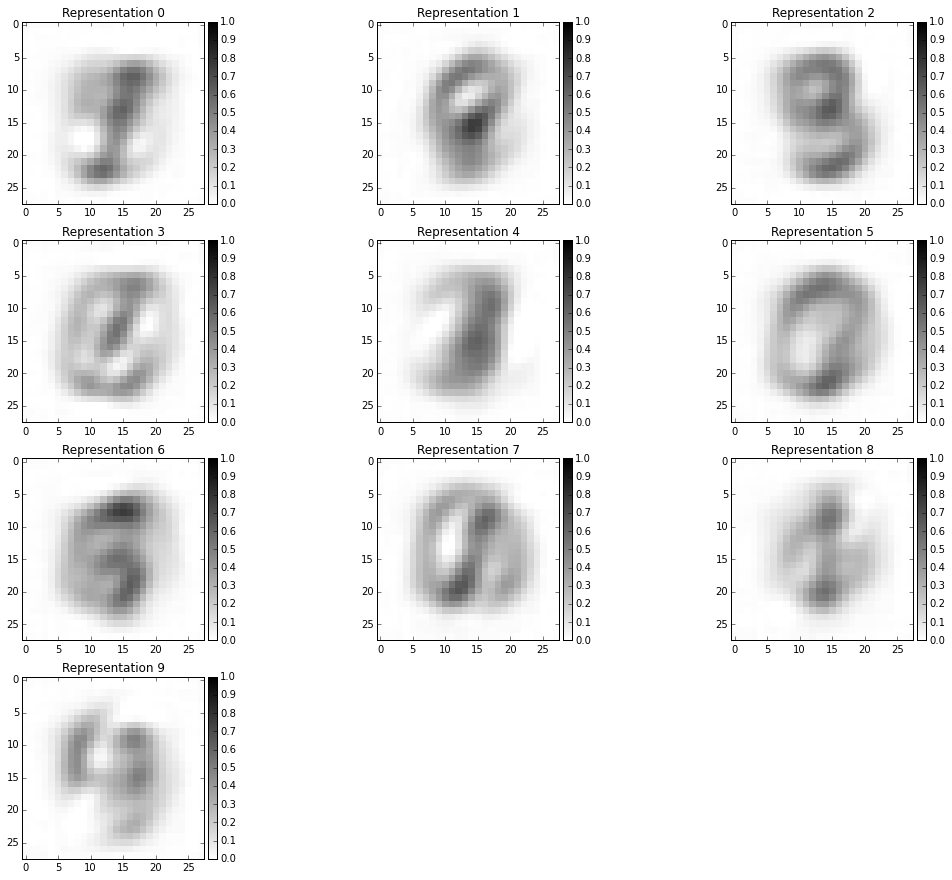

In [18]:
pl.figure(figsize=(18, 15))
for r in xrange(10):
    pl.subplot(4, 3, r + 1)
    X_enc = np.zeros((1, 10), dtype=np.float32)
    X_enc[:,r] = 2
    X_rec = decode(X_enc)
    
    pl.title('Representation %d' % r)
    nice_imshow(pl.gca(), X_rec.squeeze(), vmin=0, vmax=1, cmap=cm.binary)

## With only 2 representation neurons

If we use only 2 representation neurons, the advantage is that we get make a 2D scatter plot of our data. The autoencoder performs dimensionality reduction.

In [19]:
# - Build the encoder pipeline
encoder = models.Sequential()
encoder.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28,28)))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
encoder.add(Convolution2D(32, 3, 3, border_mode='valid'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))
encoder.add(Flatten())
encoder.add(Dense(128))
encoder.add(Dense(2))

encode = theano.function([encoder.get_input(train=False)], encoder.get_output(train=False))

# - Decoder
decoder = models.Sequential()
decoder.add(Dense(128, input_shape=(2,)))
decoder.add(Dense(32*5*5))
decoder.add(Reshape(dims=(32, 5, 5)))
#decoder.add(UpSampling2D(size=(2,2)))
decoder.add(UnPooling2D(poolsize=(2,2)))
decoder.add(ZeroPadding2D(padding=(1,1)))
decoder.add(Convolution2D(32, 3, 3, border_mode='same'))
#decoder.add(UpSampling2D(size=(2,2)))
decoder.add(UnPooling2D(poolsize=(2,2)))
decoder.add(ZeroPadding2D(padding=(2,2)))
decoder.add(Convolution2D(1, 5, 5, border_mode='same'))

decode = theano.function([decoder.get_input(train=False)], decoder.get_output(train=False))

# - Chain everything to build model
model = models.Sequential()

# Add a noise layer to get a denoising autoencoder. This helps avoid overfitting
inlayer = GaussianNoise(sigma=0.3, input_shape=(1, 28,28))

model.add(inlayer)
model.add(encoder)
model.add(decoder)

#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
model.compile(loss='mean_squared_error', optimizer='adadelta')

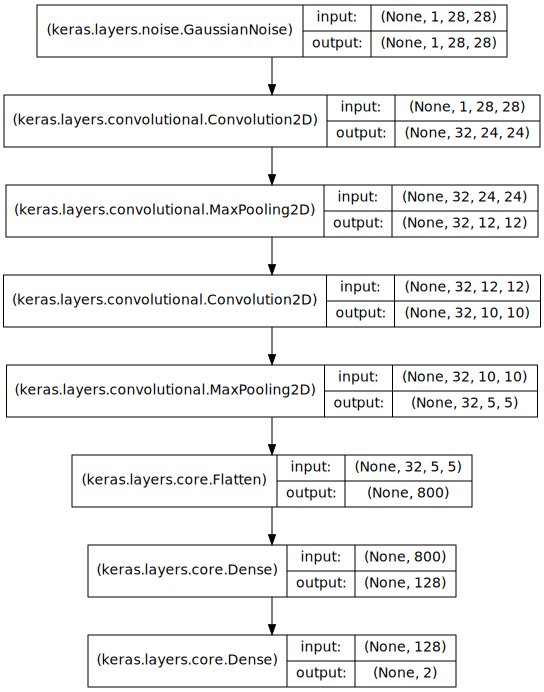

In [20]:
import keras.utils.visualize_util as vutil
from IPython.display import SVG

#SVG(vutil.to_graph(model, recursive=True, show_shape=True).create(prog='dot', format="svg"))
SVG(vutil.to_graph(encoder, recursive=True, show_shape=True).create(prog='dot', format="svg"))
#SVG(vutil.to_graph(decoder, recursive=True, show_shape=True).create(prog='dot', format="svg"))

In [21]:
nb_epoch = 10
batch_size = 128

history = model.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s - loss: 0.0859 - acc: 0.0862 - val_loss: 0.0617 - val_acc: 0.1041
Epoch 2/10
60000/60000 [==============================] - 49s - loss: 0.0574 - acc: 0.1020 - val_loss: 0.0576 - val_acc: 0.1192
Epoch 3/10
60000/60000 [==============================] - 49s - loss: 0.0570 - acc: 0.1135 - val_loss: 0.0583 - val_acc: 0.1216
Epoch 4/10
60000/60000 [==============================] - 49s - loss: 0.0568 - acc: 0.1158 - val_loss: 0.0583 - val_acc: 0.1262
Epoch 5/10
60000/60000 [==============================] - 49s - loss: 0.0567 - acc: 0.1202 - val_loss: 0.0601 - val_acc: 0.1294
Epoch 6/10
60000/60000 [==============================] - 49s - loss: 0.0566 - acc: 0.1210 - val_loss: 0.0593 - val_acc: 0.1289
Epoch 7/10
60000/60000 [==============================] - 49s - loss: 0.0566 - acc: 0.1254 - val_loss: 0.0588 - val_acc: 0.1382
Epoch 8/10
60000/60000 [==============================

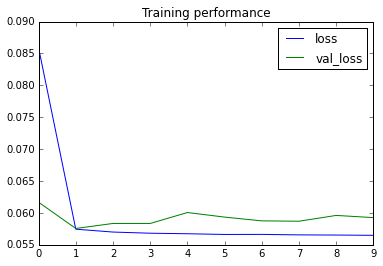

In [22]:
pl.figure()
pl.title('Training performance')
pl.plot(history.epoch, history.history['loss'], label='loss')
pl.plot(history.epoch, history.history['val_loss'], label='val_loss')
pl.legend()

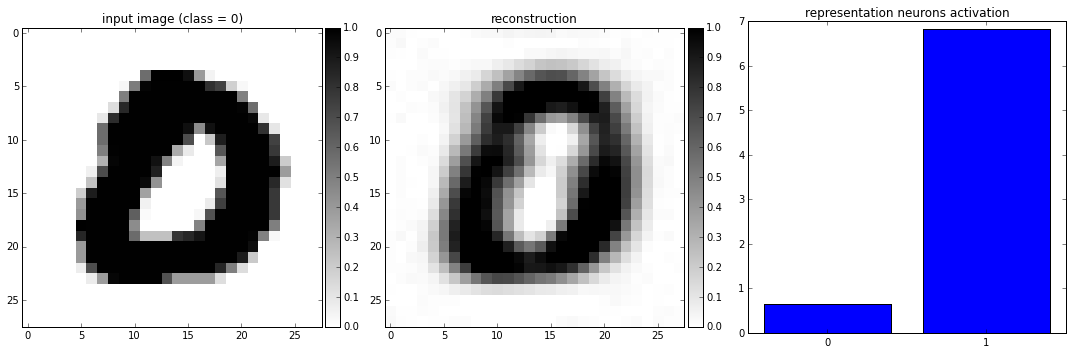

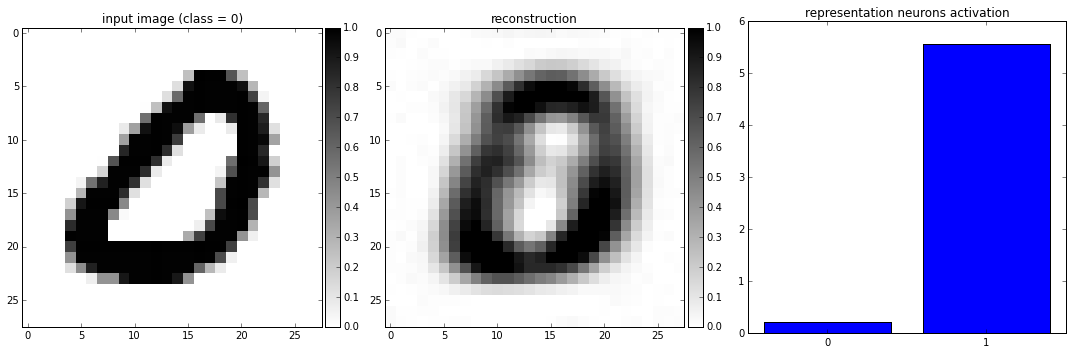

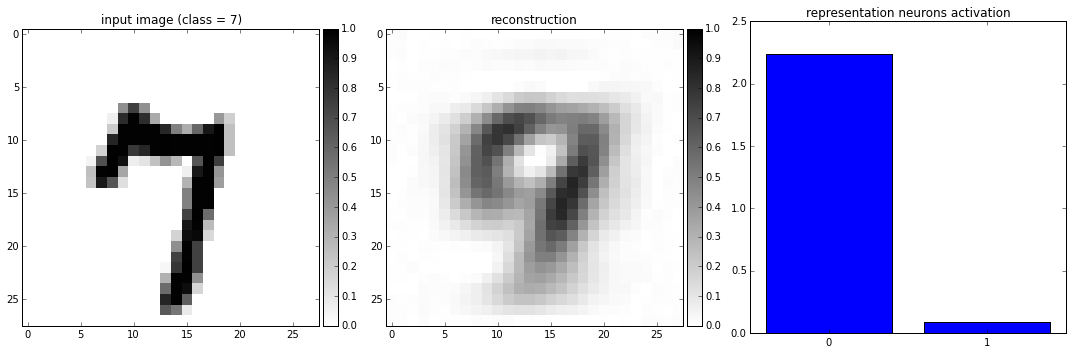

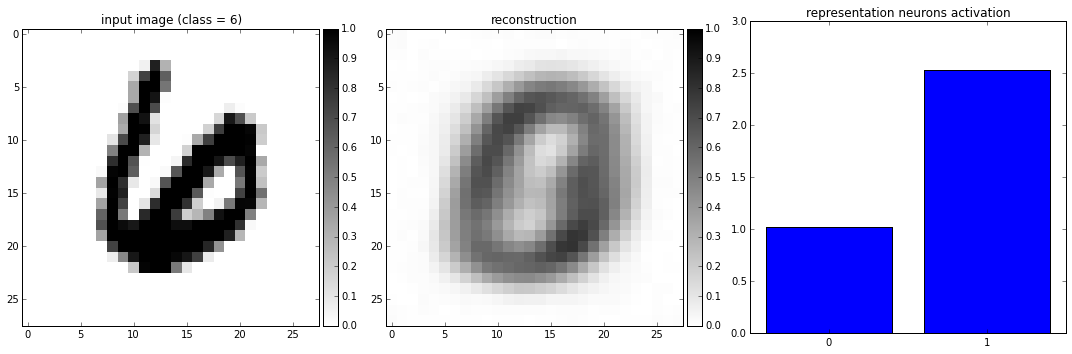

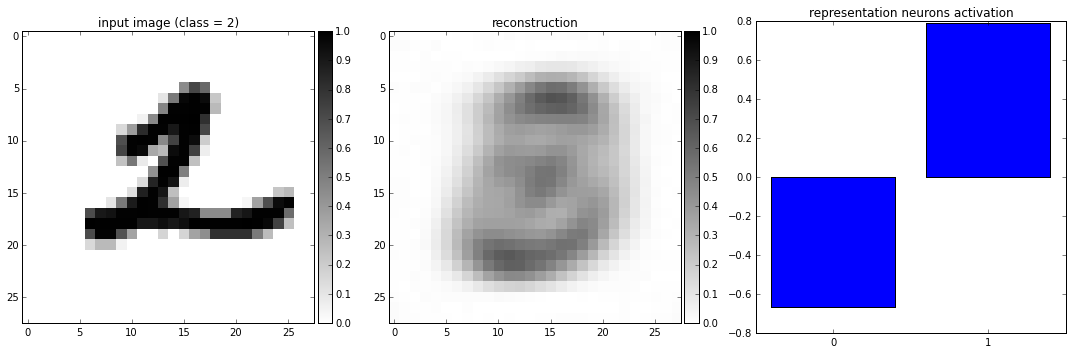

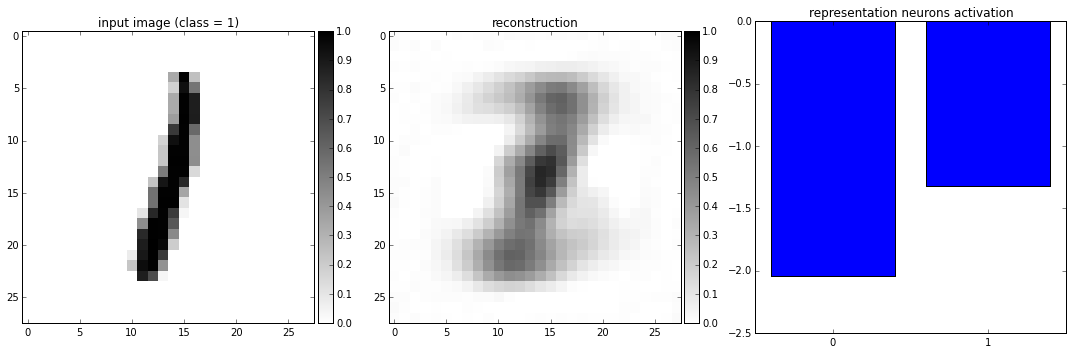

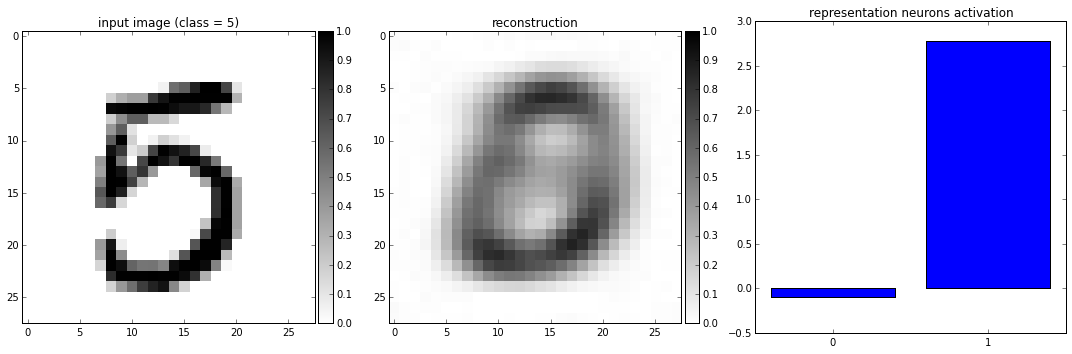

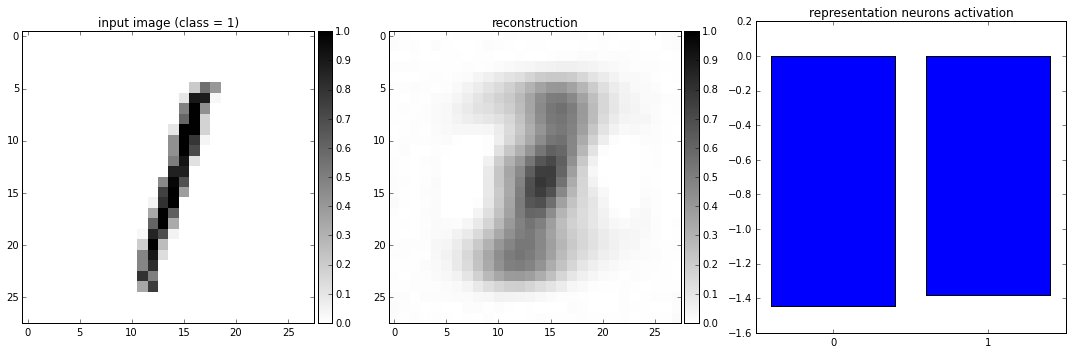

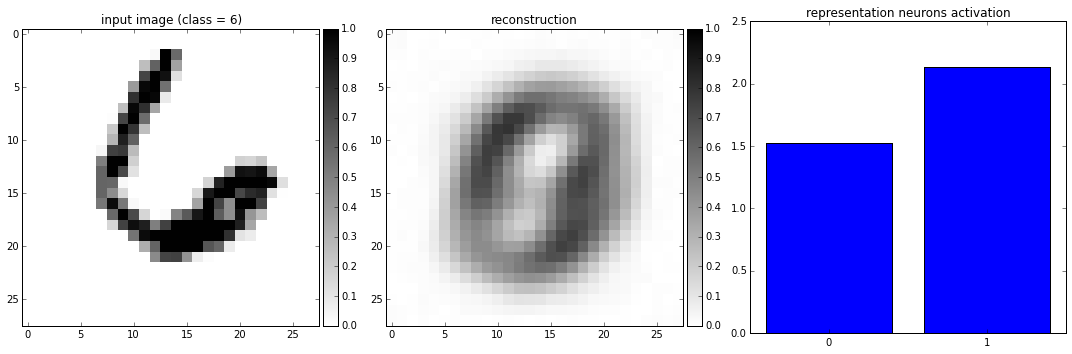

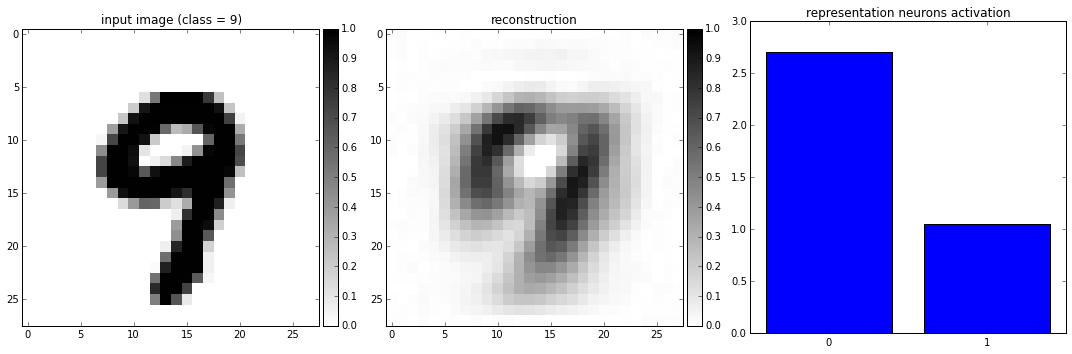

In [23]:
import random
indices = np.array(random.sample(xrange(X_test.shape[0]), 10))
X = X_test[indices]
X_pred = model.predict(X)
X_repr = encode(X)

for i in xrange(X.shape[0]):
    compare_input_reconstruction(X[i].squeeze(), X_pred[i].squeeze(), X_repr[i],
                                clsname=y_test[indices[i]])

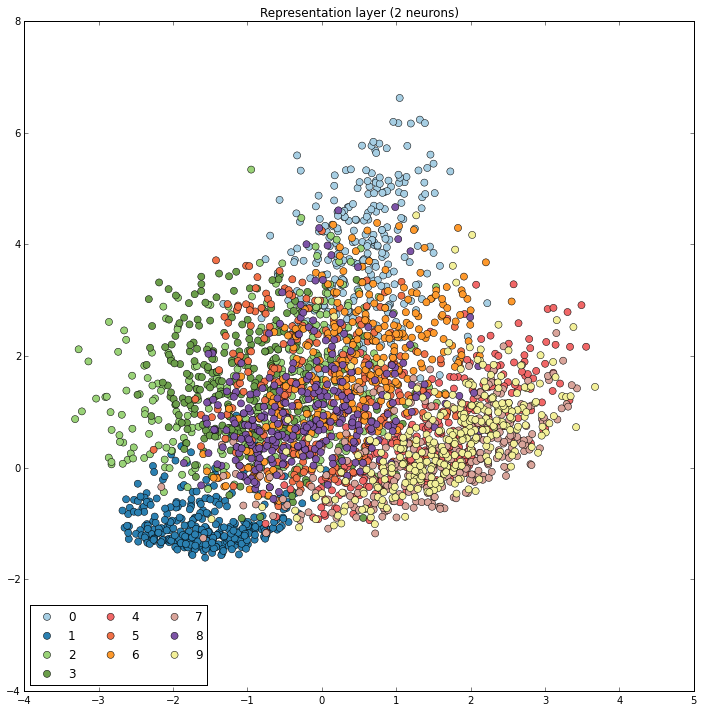

In [24]:
X_test_repr = encode(X_test)

import matplotlib as mpl

indices = random.sample(xrange(X_test_repr.shape[0]), 3000)
points = X_test_repr[indices]
labels = y_test[indices]

norm = mpl.colors.Normalize(vmin=0, vmax=10)
m = cm.ScalarMappable(norm=norm, cmap=cm.Paired)
colors = m.to_rgba(labels)

pl.figure(figsize=(12, 12))
pl.title('Representation layer (2 neurons)')

scatters = []
for lid in np.unique(labels):
    mask = labels == lid
    sc = pl.scatter(points[mask, 0], points[mask, 1], c=colors[mask], linewidth=0.5, s=50)
    scatters.append(sc)
pl.legend(scatters, np.arange(10), scatterpoints=1, loc='lower left', ncol=3, fontsize=12)